In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts
from numpy import random as rnd
from pylcp.common import progressBar
import pandas as pd
import magpylib as mg
import numpy.random 
import magpylib as magpy
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import rv_continuous
import concurrent.futures as cf
from scipy.interpolate import griddata
from eigenshuffle import eigenshuffle_eig
import matplotlib.cm as cm

# Setting up constants

In [2]:
np.sqrt(72)/2-3

1.2426406871192848

In [3]:
def sat_i(g,l):
    sat = (2*np.pi**2)*cts.hbar*cts.c*g/l**2
    return sat

In [4]:
import numpy as np

# Constants
k_B = 1.380649e-23  # Boltzmann constant in J/K
T = 723.15  # Temperature in Kelvin
m = 173 * 1.66054e-27  # Mass of Yb-173 atom in kg

# Mean velocity
mean_velocity = np.sqrt((8 * k_B * T) / (np.pi * m))

# Standard deviation of velocity
std_dev_velocity = np.sqrt(k_B * T / m)

print("Mean Velocity:", mean_velocity, "m/s")
print("Standard Deviation of Velocity:", std_dev_velocity, "m/s")

Mean Velocity: 297.49397280855686 m/s
Standard Deviation of Velocity: 186.4267009435587 m/s


In [5]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = mean_velocity
sd_yb = std_dev_velocity


klab = 2*np.pi*25068.2222
# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
Blab = -67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L =  48*1e-3
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16
x0 = 1/klab  # cm
t0 = 1/gammalab  # s
#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,b_0L)

-0.067 16 0.048


In [6]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # distance in cm
t0 = 1/gammalab # time in s
vc = x0/t0*(1/100) # velcoity in cm/s for conversion back to s.i units
Fc = cts.hbar*klab*100*gammalab # force in newtond for conversion back to s.i units

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)


6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -30.52874111941582 21.871336921372524


# Magnetic field profile

In [7]:
cts.hbar*klab*(250)/cts.value('Bohr magneton')*1e3

0.44776692453043865

In [8]:
def mag(R,B_0,alpha,l):
    if R[2] < 0 or R[2] > l:
       return  np.array([0,0,0])
    else:
        return np.array([B_0 + alpha*np.sqrt(1 -R[2]/l),0,0])

In [9]:
mag([0,0,l],b_0,alpha,l) == [b_0,0,0]

array([ True,  True,  True])

In [10]:
zeeman_prof = magpy.Collection()
j = 30
n = 2
c = 9 #angle of first bar
d =  39#angle of second bar
b = 5# distnace the two section of the array are apart from each other


mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k")
)
angles = np.linspace(0, 360, n, endpoint=False)
for i in angles:
    cube1= magpy.magnet.Cuboid(
    dimension=(6,6,128),
    polarization=(-1.080,0,0),
    position=(51.7,0,18))
    cube2 = magpy.magnet.Cuboid(dimension= (4,4,25),
    polarization=(-1.17,0,0),
    position=(48,0,100+b),style_magnetization = mystyle)
    cube3= magpy.magnet.Cuboid(
    dimension=(6,6,128),
    polarization=(1.08,0,0),
    position=(61,0,190+b))
    cube4 = magpy.magnet.Cuboid(dimension= (4,4,25),
     polarization=(-1.17,0,0),
     position=(70,0,210),style_magnetization = mystyle)
    cube5 = magpy.magnet.Cuboid(dimension= (4,4,25),
     polarization=(-1.17,0,0),
     position=(55,0,-39),style_magnetization = mystyle)
    cube6 = magpy.magnet.Cuboid(dimension= (4,4,25),
    polarization=(-1.17,0,0),
    position=(55,0,150),style_magnetization = mystyle)

#     cube5 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(90+a+p+m,0,190))

#     cube6 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(80+a+p+m,0,200),
# )

    
    cube1.rotate_from_angax(i, 'z')
    cube1.rotate_from_angax(c, 'y',)
    cube1.rotate_from_angax(i, 'z', anchor=0)
    cube2.rotate_from_angax(i, 'z',anchor = 0)
    cube2.rotate_from_angax(i, 'z')
    cube3.rotate_from_angax(i, 'z', anchor=0)
    cube3.rotate_from_angax(-d+10, 'y')
    cube3.rotate_from_angax(i, 'z')
    cube4.rotate_from_angax(i, 'z', anchor=0)
    cube4.rotate_from_angax(i, 'z')
    cube5.rotate_from_angax(i, 'z',anchor = 0)
    cube5.rotate_from_angax(i, 'z')
    cube6.rotate_from_angax(i, 'z',anchor = 0)
    cube6.rotate_from_angax(i, 'z')
    zeeman_prof.add(cube1)
    zeeman_prof.add(cube2)
    zeeman_prof.add(cube3)
    zeeman_prof.add(cube4)
    zeeman_prof.add(cube5)
    zeeman_prof.add(cube6)
    j = j+1


 
 
  


tfmot = magpy.Collection()
N = 8
angles = [0,90,180,270]
angles_d = [45,225,225,45]
l = 5
p = [0,0,0,0,20,20,20,20]
s  = [-1,-1,1,1,1,1,-1,-1]
H = 39
q = 350
h = [-H,-H,-H,-H,H,H,H,H]
mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k")
)
for a in range(len(angles)):
    cube= magpy.magnet.Cuboid(
    dimension=(6,8,80),
    polarization=(s[a]*1.42,0,0),
    position=(h[a],h[a], h[a]+300),
    style_magnetization=mstyle )
    
    cube.rotate_from_angax(angles[a], 'z',anchor = 0)
    cube.rotate_from_angax(angles_d[a], 'z')

    tfmot.add(cube)


b_tot = magpy.Collection()
#tfmot.rotate_from_angax(45,'z')#
b_tot.add(zeeman_prof,override_parent=True)
b_tot.show()

In [24]:
27.34833-0.599

26.74933

In [25]:
17.542*np.pi/8

6.88872729115902

In [26]:
x_1 = (53-45.42789)
z_1 = 32.4-22.82468
z_2 = 120+7.5
x_2 = 73-57
21.373+181.3830
23.53454-21.37316

2.161380000000001

# mot magfield 3D

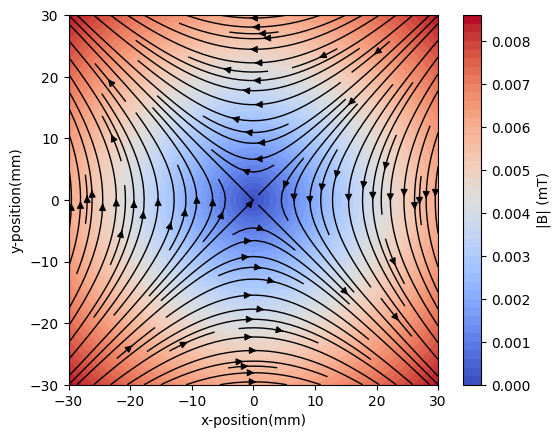

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Compute and plot field on x-y grid
grid = np.mgrid[-30:30:100j, -30:30:100j, 0:0:1j].T[0]
X, Y, _ = np.moveaxis(grid, 2, 0)

B = tfmot.getB(grid)*1e3
Bx, By, _ = np.moveaxis(B, 2, 0)
Bamp = np.linalg.norm(B, axis=2)

pc = ax.contourf(X, Y, Bamp, levels=50, cmap="coolwarm")
ax.streamplot(X, Y, Bx, By, color="k", density=1.5, linewidth=1)

# Add colorbar
fig.colorbar(pc, ax=ax, label="|B| (mT)")

# Figure styling
ax.set(
    xlabel="x-position(mm)",
    ylabel="y-position(mm)",
    aspect=1,
)

plt.show()

In [28]:
38.84/2 + 15.494

34.914

# zeeman slower magfield

In [29]:
(300**2)/((2*(6)*1e-20/mass_lab))*100

21.545494389135005

In [30]:
l = 30/x0
Blab = -50*1e-3
b_0L = 30e-3
y= np.linspace(0,2*L,1000)
r = []
for i in y:
    r.append(np.array([0,0,i]))
magg = []
for i in r:
    magg.append(mag(i,b_0L,Blab,22)[0]*1e3)

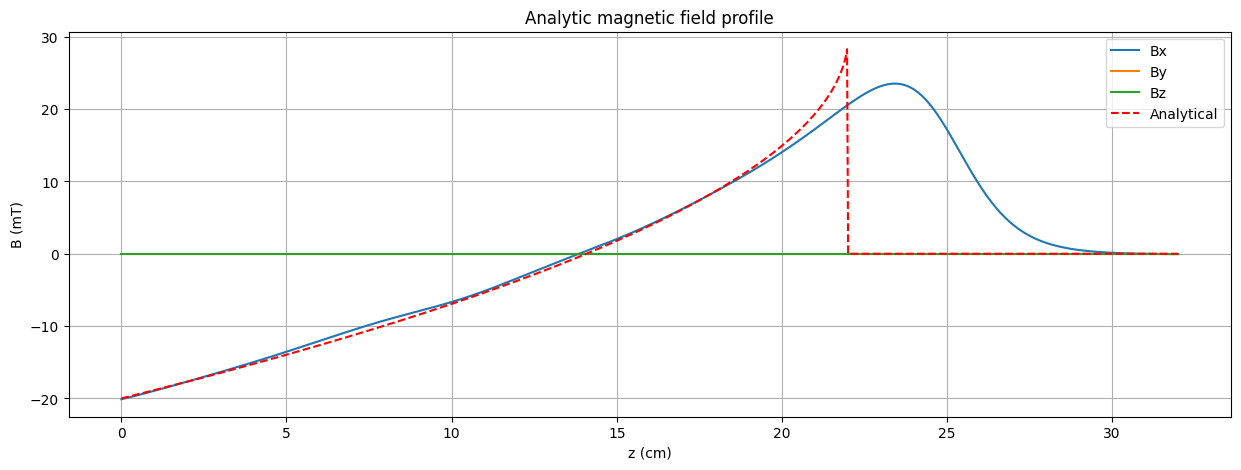

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
z = np.linspace(0,2*L,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(b_tot.getB([0,0,i*10])[0])
    b_y.append(b_tot.getB([0,0,i*10])[1])
    b_z.append(b_tot.getB([0,0,i*10])[2])
    

   
ax.plot(z,np.array(b_x)*1e3)
ax.plot(z,np.array(b_y)*1e3)
ax.plot(z,np.array(b_z)*1e3)
ax.plot(z,magg,'--',color = 'red')
#ax.plot(z,np.array(b_x)*1e3)
ax.set_xlabel('z (cm)')
ax.set_ylabel('B (mT)')
ax.legend(['Bx','By','Bz','Analytical'])
plt.grid()
plt.title( 'Analytic magnetic field profile')
bf = lambda R: cts.value('Bohr magneton')*b_tot.getB(R*10*x0)*t0/cts.hbar
# plt.ylim(15,20)
#plt.xlim(20,25)



# mot mag profile

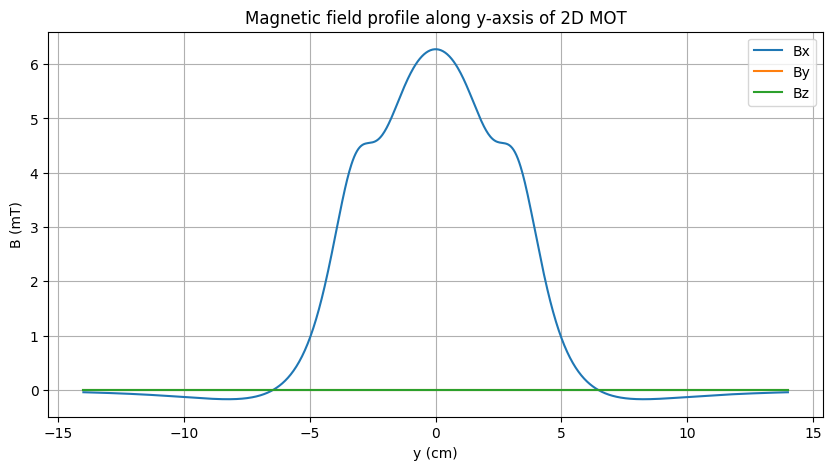

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
z = np.linspace(-14,14,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(b_tot.getB([0,i*10,265])[0])
    b_y.append(b_tot.getB([0,i*10,265])[1])
    b_z.append(b_tot.getB([0,i*10,265])[2])
    

   
ax.plot(z,np.array(b_x)*1e3)
ax.plot(z,np.array(b_y)*1e3)
ax.plot(z,np.array(b_z)*1e3)
plt.xlabel('y (cm)')
plt.ylabel('B (mT)')
plt.title('Magnetic field profile along y-axsis of 2D MOT')
# plt.ylim(-10.8,10.8)
# plt.xlim(-5,5)
plt.legend(['Bx','By','Bz','Analytical'])
plt.grid()

# Setting YB 173 system

In [33]:
# Define the atomic Hamiltonian:
# i = 5/2
#g_i = -0.2592/1836.1526
#g_j = 1035
# Ahfs = 59.521*1e6/gammalab
# Bhfs = 601.87*1e6/gammalab
yb_is = {}
E_e_D2 = {}
E_g_D2 = {}
isotopes = ['174','173','171']
two_pi = 2*np.pi
ahfs = [0, two_pi*59.521*1e6/gammalab,two_pi*59.521*1e6/gammalab]
bhfs = [0, two_pi*601.87*1e6/gammalab,0]
g_j = [0, -0.2592/1836.1526, -0.2592/1836.1526]
I_l = [0, 5/2, 1/2]
for i in range(3):
    I = I_l[i]
    H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    0, I, 0,g_j[i],
        Ahfs = 0, Bhfs=0, Chfs=0,
        muB=1)# ground state 1s0#173-gI factor -0.2592
    H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    1, I, 1.035, g_j[i],
        Ahfs=ahfs[i],Bhfs = bhfs[i] ,Chfs= 0,
        muB=1)#
    #
    #excited state 1p1 changed Shfs from 1e6 to 1e7
    #changed to yb-174
    dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, I)
    E_e_D2[isotopes[i]] = np.unique(np.diagonal(H_e_D2))
    E_g_D2[isotopes[i]] = np.unique(np.diagonal(H_g_D2))
    hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
    hamiltonian_D2.add_H_0_block('g', H_g_D2)
    hamiltonian_D2.add_H_0_block('e', H_e_D2)
    hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
    hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
    hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



    #ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

    bf = lambda R: cts.value('Bohr magneton')*b_tot.getB(R*10*x0)*t0/cts.hbar
    alpha = cts.value('Bohr magneton')*(-53*1e-3)*t0/cts.hbar
    b_0 = cts.value('Bohr magneton')*(33*1e-3)*t0/cts.hbar 
    bf2 = lambda R: mag(R,b_0,alpha,19/x0)
    linGrad = pylcp.magField(lambda R: bf(R))
    yb_is[isotopes[i]] = hamiltonian_D2

In [34]:

def t(b,j,k,n):
    k = yb_is[f'{j}'].return_full_H({'g->e':np.array([0,0,0])},b)[k:n,k:n]
    return k

In [35]:
iso = [171,173,174]
k = [[2,8],[6,24],[1,4]]
ham_e = {}
for n in range(3) :
    r = np.linspace(0,30,10000)/x0
    f_l = np.array([[0,0,i] for i in r ])
    b =   [bf(i) for i in f_l]
    b_1 = [i[0] for i in b]
    b_s = []
    b_s_units = []
    for i in b:
        b_s.append([0,i[0],0])
    ham = np.array([t(i,iso[n],k[n][0],k[n][1]) for i in b_s] )
    print(len((np.linalg.eigvals(ham[0]))))
    ham_e[f'{iso[n]}'],ham2_v = eigenshuffle_eig(ham)
for  i in b_s:
    b_s_units.append(i[1]/cts.value('Bohr magneton')/t0*cts.hbar)

6
18
3


# zeeman shifts calculations

c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



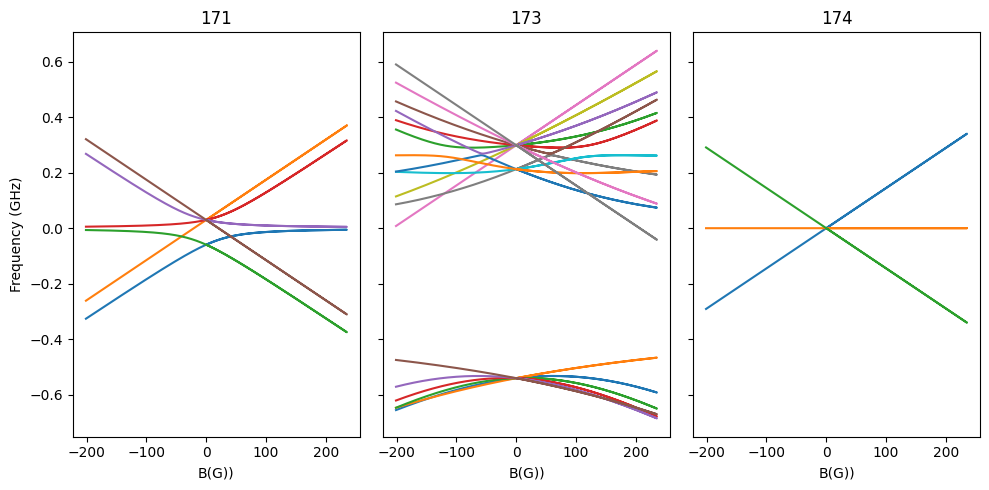

In [36]:
fig,ax = plt.subplots(1, 3, figsize=(10, 5),sharey= True)
num = [6,18,3]
c = 0
for keys in ham_e:
    eig1 = {}
    mfn = 0
    for i in range(0,num[c]):
        eig1[f'{i}'] = []
    for i in range(len(b_s)):
        mfn = mfn+1
        kh = ham_e[keys][i]
        for j in range(len(kh)):
            eig1[f'{j}'].append(kh[j]*gammalab*1/(two_pi*1e9))
    n = 0
    for i in eig1:
        n = n+1
        if n >= 0:
            ax[c].plot(np.array(b_s_units)*1e4,eig1[f'{i}'],label = f'{i}')
            #ax[c].legend()
       
    c = c+1
ax[0].set_xlabel('B(G))')

ax[1].set_xlabel('B(G))')
ax[2].set_xlabel('B(G))')
ax[0].set_ylabel('Frequency (GHz)')
ax[0].set_title('171')
ax[1].set_title('173')
ax[2].set_title('174')
# ax[0].set_xlim([-10,10])
# ax[1].set_xlim([-100,100])
# ax[2].set_xlim([-100,100])
# ax[0].set_ylim([-0.3,0.3])
# ax[1].set_ylim([0,0.5])
# ax[2].set_ylim([-1,1])

plt.tight_layout()

# calculating and ploting force proifle

In [44]:
    #when using ideal magfield it has to be off due
i = 0
bf = lambda R: cts.value('Bohr magneton')*b_tot.getB(R*10*x0)*t0/cts.hbar
linGrad = pylcp.magField(lambda R: bf2(R))
b_0 = cts.value('Bohr magneton')*(30e-3)*t0/cts.hbar
alpha = cts.value('Bohr magneton')*(-50e-3)*t0/cts.hbar
bf2 = lambda R: mag(R,b_0,alpha,22/x0)
det = np.linspace(-30,0,100)
force_prof = {}
force_prof_real = {}
iso = ['174','171','173']

for keys in iso:

        laserBeams = {}
        laserBeams['g->e'] = pylcp.laserBeams([
        {'kvec':np.array([0, 0, -1]), 's': 3,'pol_coord':'spherical', 'pol':np.array([1,0,1]), 'delta': (E_e_D2[keys][i]-E_g_D2[keys][0]) - 15.2*gamma,'wb':0.5/x0}],
        beam_type=pylcp.gaussianBeam)
        linGrad = pylcp.magField(lambda R: bf2(R))
        rateeq_zeeman_perf =  pylcp.rateeq(laserBeams, linGrad, yb_is[keys], include_mag_forces=False)
    #real field calculations
        linGrad = pylcp.magField(lambda R: bf(R))

    #rateeq setup
        rateeq_zeeman = pylcp.rateeq(laserBeams, linGrad, yb_is[keys], include_mag_forces=False)
        x = np.arange(0, 45, 0.05)/(x0)
        v = np.arange(-18, 450,5)/vc


        X, V = np.meshgrid(x, v)

        Rvec = np.array([np.zeros(X.shape), np.zeros(X.shape), X])
        Vvec = np.array([np.zeros(V.shape), np.zeros(V.shape), V])

        rateeq_zeeman.generate_force_profile(Rvec, Vvec, name=f'{keys}', progress_bar=True)
        #rateeq_zeeman_perf.generate_force_profile(Rvec, Vvec, name = f'{keys}', progress_bar=True)
        #force_prof[keys] = rateeq_zeeman_perf.profile[f'{keys}']
        force_prof_real[keys] = rateeq_zeeman.profile[f'{keys}']
        i = i +1

Completed in 3:31.                                                  


c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\rateeq.py:264: ComplexWarning:

Casting complex values to real discards the imaginary part



Completed in 5:40.                                                  
Completed in 5:56.                                                  


## 2d mot force profile and laser system setup

In [ ]:
#the set up the 2d mot 
det = -10
s = 3

# Define the laser beams:
laserBeams_2dmot = pylcp.laserBeams(
    [{'kvec':k*np.array([ 1.,  0., 0.]), 's':s, 'pol':-1, 'delta': E_e_D2[2] - E_g_D2[0] +  det*gamma},
     {'kvec':k*np.array([-1.,  0., 0.]), 's':s, 'pol':-1, 'delta': E_e_D2[2] - E_g_D2[0] +  det*gamma},
     {'kvec':k*np.array([ 0.,  1,  0.]), 's':s, 'pol': 1, 'delta': E_e_D2[2] - E_g_D2[0] +  det*gamma},
     {'kvec':k*np.array([ 0., -1., 0.]), 's':s, 'pol': 1, 'delta': E_e_D2[2] - E_g_D2[0] +  det*gamma}],
beam_type= pylcp.infinitePlaneWaveBeam
)
rateeq_2dmot = pylcp.rateeq(laserBeams_2dmot, linGrad, hamiltonian_D2, include_mag_forces=True)

In [50]:
180*(0.5**2*np.pi)

141.3716694115407

In [ ]:
y = np.arange(-10, 10, 0.4)/x0
v_y = np.arange(-5, 5, 0.04)/vc

Y, V_y = np.meshgrid(y,v_y)

Rvec = np.array([np.zeros(Y.shape), Y,np.full(Y.shape,25/x0)])
Vvec = np.array([np.zeros(V_y.shape), V_y, np.zeros(V_y.shape)])

rateeq_2dmot.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)

## plotting of the force profile

C:\Users\benfo\AppData\Local\Temp\ipykernel_18388\816919794.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



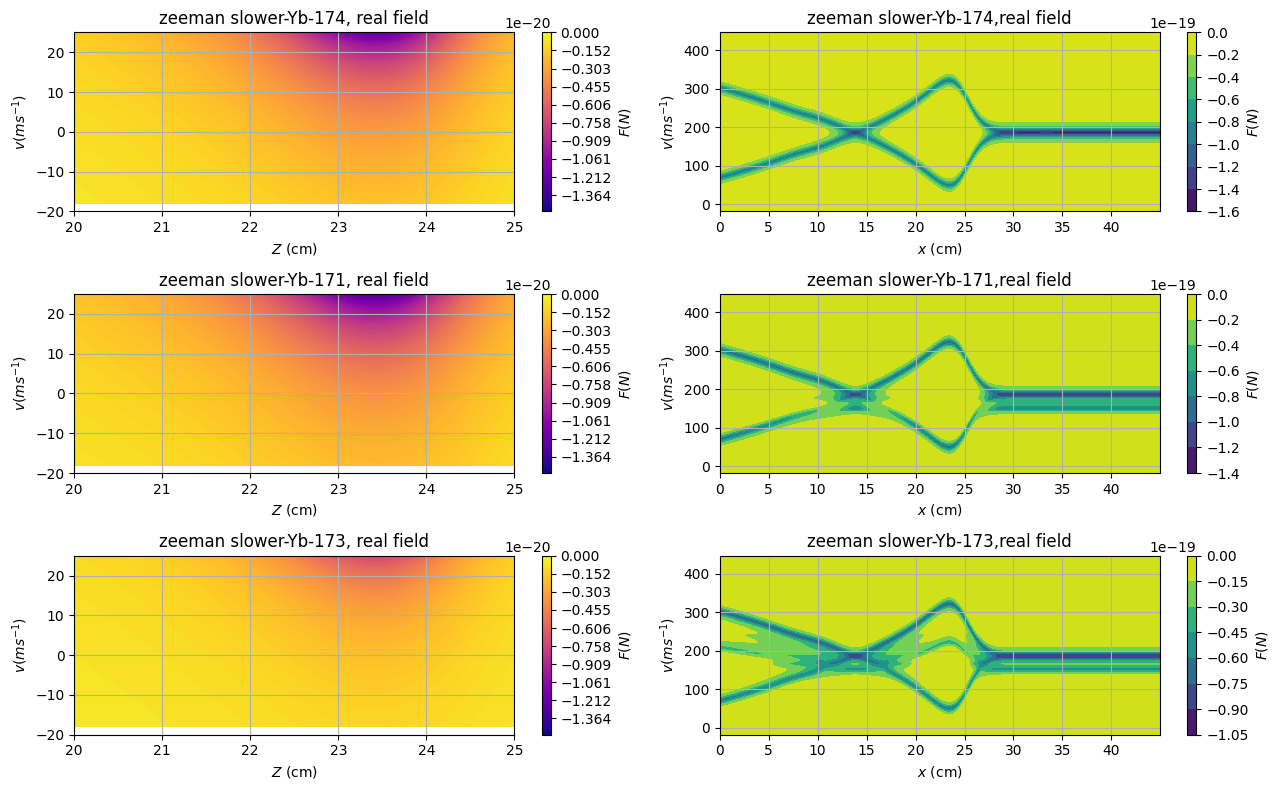

In [51]:
fig,ax = plt.subplots(3, 2, figsize=(13, 8))
ax = ax.flatten() 
cmap_reversed = plt.cm.get_cmap('plasma')
Fc = gammalab*cts.hbar*klab*100
atomic_mass = '173'
x = np.arange(0, 45, 0.05)/(x0)
v = np.arange(-18, 450,5)/vc
n = 0
for keys in force_prof_real:
#levels = np.linspace( -0.15e-19,0, 1000)
    vmin, vmax = -0.15e-19, 0  # Focus only on this range
    im1 = ax[n].contourf(np.array(x)*x0, np.array(v)*vc, force_prof_real[keys].F[2]*Fc ,levels = np.linspace(vmin, vmax, 100), cmap='plasma', vmin=vmin, vmax=vmax)
    im2 = ax[n+1].contourf(np.array(x)*x0, np.array(v)*vc, force_prof_real[keys].F[2]*Fc)
    fig.subplots_adjust(left=0.08, wspace=0.2)

    cb1 = plt.colorbar(im1)
    cb2 = plt.colorbar(im2)

    cb1.set_label('$F(N)$')
    cb2.set_label('$F(N)$')
    ax[n].set_xlabel('$Z$ (cm)')
    ax[n].set_ylabel('$v (ms^{-1})$')
    ax[n].set_title(f'zeeman slower-Yb-{keys}, real field')
    ax[n+1].set_ylabel('$v (ms^{-1})$')
    ax[n+1].set_xlabel('$x$ (cm)')
    ax[n+1].set_ylabel('$v (ms^{-1})$')
    ax[n+1].set_title(f'zeeman slower-Yb-{keys},real field')
    ax[n+1].grid()
    ax[n].grid()  
    ax[n].set_ylim(-20,25)
    ax[n].set_xlim(20,25)
    n = n+2
    #plt.ylim(300,400)
plt.tight_layout()

In [46]:
i = 130e-3/(2*np.pi*(0.5/100)**2)
1e-6*(np.sqrt(i*2/((cts.c*cts.epsilon_0))))*2.997*cts.e*cts.value('Bohr radius')/cts.hbar


190.2672878601559

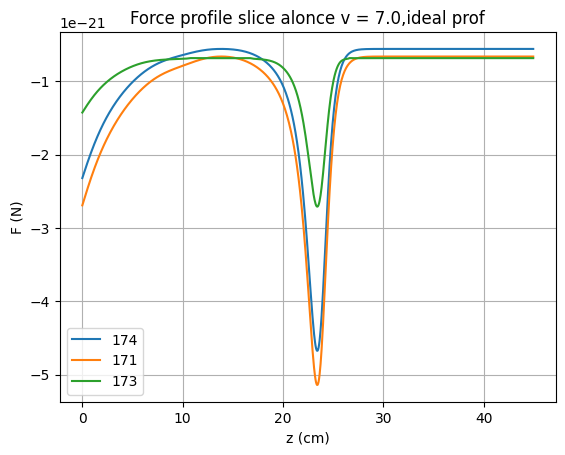

In [47]:
x = np.arange(0, 45, 0.05)/(x0)
v = np.arange(-18, 450,5)/vc
velo = int(len(v)/18)
for keys in force_prof_real:
    plt.plot(np.array(x)*x0, force_prof_real[keys].F[2][velo,:]*Fc,label = f'{keys}')
plt.legend()
plt.xlabel('z (cm)')
plt.ylabel('F (N)')
plt.title(f'Force profile slice alonce v = {v[velo]*vc},ideal prof')

plt.grid()

C:\Users\benfo\AppData\Local\Temp\ipykernel_18388\1576094858.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



KeyError: 'Fz'

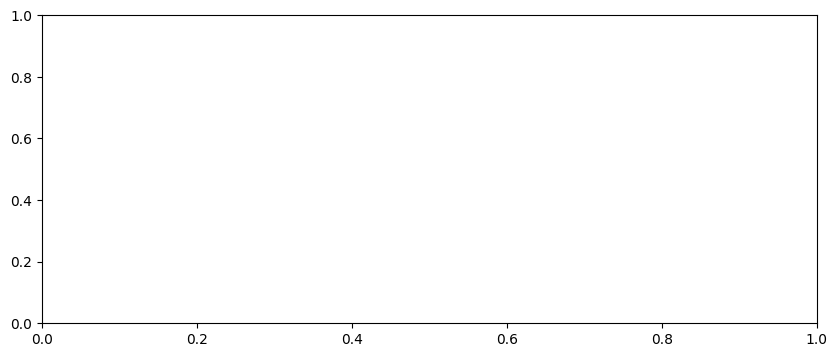

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Define a reversed colormap
cmap_reversed = plt.cm.get_cmap('viridis_r')

# Force conversion factors
Fc = gammalab * cts.hbar * klab * 100

# First contour plot
im1 = ax.contourf(np.array(x) * x0, np.array(v) * vc, 
                  rateeq_zeeman.profile['Fz'].F[2] * Fc, 
                  vmin=-1.1e-19, vmax=0, alpha=0.6, cmap='Blues')

# Second contour plot (Overlayed)
im2 = ax.contourf(np.array(x) * x0, np.array(v) * vc, 
                  rateeq_zeeman_perf.profile['Fz_perf'].F[2] * Fc, 
                  vmin=-1.1e-19, vmax=0, alpha=0.6, cmap='Reds')

# Adjust layout
fig.subplots_adjust(left=0.08, wspace=0.2)

# Correct way to add colorbars
cb1 = plt.colorbar(im1, ax=ax)
cb2 = plt.colorbar(im2, ax=ax)

# Labels
cb1.set_label('$F(N)$')
cb2.set_label('$F(N)$')

ax.set_xlabel('$Z$ (cm)')
ax.set_title('Zeeman Slower - Yb-173')

# Enable Grid
ax.grid()

# Display the plot
plt.tight_layout()
plt.show()


# Modeling velocity distribution of Yb-173 atoms out of 450 degree oven

In [ ]:
def find_nearest_value(lst, target):
    nearest = min(lst, key=lambda x: abs(x - target))
    return nearest

In [ ]:
E_e_D2['173']*gammalab

In [ ]:
# Constants
k_B = cts.k  # Boltzmann constant in J/K
 # Atomic mass of Yb-173
mass_kg = mass_lab  # Convert to kilograms
temperature = 490 + 273.15  # Convert Celsius to Kelvin

# Velocity Probability Function
def p(m, T, v):
    return (m / (k_B * T))**2 * np.exp(-m * v**2 / (2 * k_B * T)) * (v**3) / 2

In [ ]:
class MaxwellBoltzmann(rv_continuous):
    def _pdf(self, v):
        return p(mass_kg, temperature, v)

# Define the custom distribution
maxwell_boltzmann = MaxwellBoltzmann(a=0, name="Maxwell-Boltzmann")

In [ ]:
sd_t

In [ ]:
vbeam = np.sqrt(3*k_B * temperature / mass_lab)
sd_t = mean*35e-3/(vbeam*np.sqrt(2*np.log(2)))

size = 10000 # Number of samples
velocities_a = maxwell_boltzmann.rvs(size=size)
velocities = [i for i in velocities_a if i < 300]
angle = np.random.normal(0,sd_t,size)
velocities_x = []
velocities_y = []
for i in velocities:
    k1 = np.random.randint(0,len(angle))
    k2 = np.random.randint(0,len(angle))
    velocities_y.append(i*np.tan(angle[k1]))
    velocities_x.append(i*np.tan(angle[k2]))
velocities_3 = []
for i in range(len(velocities)):
    velocities_3.append([velocities_x[i], velocities_y[i], velocities[i]])
# Display the sampled velocities
print(len(velocities))
plt.hist(velocities_x, bins=100, density=True)
plt.grid()

# calculating trajectories 

In [ ]:
def simulate_trajectory(v_0, t_span,f_interp,mass_lab):
    v, s_t,t =[], [], []

    di = 0
      # Initial conditions
    s = [0,0,0]

    for q in range(len(t_span)):
        v_x = v_0[0]

        v_y = v_0[1]

        v_z = v_0[2]
    
        dt = t_span[q] - di


        # Interpolate the force profile
        a = f_interp((v_z, s[2]))/mass_lab
        
        #print(a*mass_lab)
        s_x = v_x*dt + s[0]
        
        s_y = v_y*dt + s[1]

        s_z = (1/2)*a*(dt**2) + v_z*dt + s[2]
        
        v_x = v_x

        v_y = v_y

        v_z = v_z + a*dt

        if s_z >= 0.26 or v_z <-17 or v_z > 400:
            break
        # Append values
        s_t.append([s_x,s_y,s_z])

        v.append([v_x,v_y,v_z])

        t.append(t_span[q])

        di = t_span[q]

        v_0 = (v_x,v_y,v_z)
        
        s = (s_x,s_y,s_z)
 

    return s_t,v,t

In [ ]:
def simulate_trajectory_2dmot(v_0, s,t_span):

    x_t, y_t, v_tx, v_ty, t = [], [], [], [], []

    di = 0  # Initial time step 
    b = 0  # Step counter

    for q in range(len(t_span)):
        v_x = v_0[0]
        v_y = v_0[1]
        v_z = v_0[2] 

        dt = (t_span[q] - di) / t0  

    
        rateeq_2dmot.generate_force_profile(s,v_0, name='Fz', progress_bar=False)
        #print(rateeq.profile['Fz'].F[0])

        # Acceleration (force divided by mass)
        a_x = rateeq.profile['Fz'].F[0] / mass
        a_y = rateeq.profile['Fz'].F[1] / mass
        a_z = 0  
   
        # Update position
        s_x = (1 / 2) * a_x * (dt ** 2) + v_x * dt + s[0]
        s_y = (1 / 2) * a_y * (dt ** 2) + v_y * dt + s[1]
        s_z = (1 / 2) * a_z * (dt ** 2) + v_z * dt + s[2]

        # Update velocity
        v_x += a_x * dt
        v_y += a_y * dt
        v_z += a_z * dt


        # Append values
        x_t.append(s_x)
        y_t.append(s_y)
        v_tx.append(v_x)
        v_ty.append(v_y)
        t.append(t_span[q])

        # Update initial conditions for the next step
        di = t_span[q]
        v_0 = [v_x, v_y, v_z]
        s = [s_x, s_y, s_z]
        #print(s)
        #print(s_0)
        # Stop condition
        if s_z * x0 >= 40:  # Stop if z-position exceeds threshold
            break

    return x_t


In [ ]:
0.01/1000

In [ ]:
# # this is the real field profile 
# v_3_r = []
# t_a_r = []
# t_max = 0.01
# t_span = np.linspace(0, t_max, 1000)
# x = np.arange(0, 45, 0.05)/(x0)
# v = np.arange(-18, 450,0.5)/vc
# z_t_r = []
# #for key in force_profiles:
# f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)*x0/100),rateeq_zeeman.profile['Fz'].F[2]*Fc,method='linear')
# for i in range(len(velocities)):
#         s_t,v_t,t = simulate_trajectory(velocities_3[i], t_span, f_interp,mass_lab)
#         t_a_r.append(t)
#         v_3_r.append(v_t)
#         z_t_r.append(s_t)

# c1 = 0
# for i in range(len(v_3_r)):
#         if v_3_r[i][-1][2] < 20  and v_3_r[i][-1][2] > 10 and z_t_r[i][-1][2] >= 0.25:
#                 c1 = c1+1 
              
# print(c1)
# print(c1/len(velocities)*100)

In [ ]:
# this is the ideal field profle

t_max = 0.05
t_span = np.linspace(0, t_max, 1000)
x = np.arange(0, 45, 0.05)/(x0)
v = np.arange(-18, 450,5)/vc
traj = {}
vel_1 = np.array([[1,1,100],[1,1,200],[1,1,250],[1,1,300]])
for keys in force_prof_real:
        v_3 = []
        t_a = []
        z_t = []
        f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)*x0/100),force_prof_real[keys].F[2]*Fc,method='linear')
        for i in range(len(velocities)):
                s_t,v_t,t = simulate_trajectory(velocities_3[i], t_span, f_interp,mass_lab)
                t_a.append(t)
                v_3.append(v_t)
                z_t.append(s_t)

        c1 = 0
        for i in range(len(v_3)):
                if v_3[i][-1][2] < 30  and  v_3[i][-1][2] > 10 and z_t[i][-1][1] < 0.01 and z_t[i][-1][1]> -0.01 and  z_t[i][-1][2] >= 0.25:
                        c1 = c1+1 
        traj[keys] = [v_3,t_a,z_t]      
        print(c1)
        print(c1/len(velocities)*100)
     


In [ ]:
15*gammalab/(2*np.pi*1e6)

In [ ]:
        c1 = 0
        for i in range(len(v_3)):
                if v_3[i][-1][2] < 30  and  v_3[i][-1][2] > 10 and z_t[i][-1][1] < 0.005 and z_t[i][-1][1]> -0.005 and  z_t[i][-1][2] >= 0.25:
                        c1 = c1+1 
        traj[keys] = [v_3,t_a,z_t]      
        print(c1)
        print(c1/len(velocities)*100)
     

In [ ]:
v_z_dict = {} 
s_z_dict = {}
s_x_dict = {}
s_y_dict = {}
t_a_dict = {}
for keys in traj:
    v_3 = traj[keys][0]
    t_a = traj[keys][1]
    z_t = traj[keys][2]   
    v_x = []
    v_y = []
    v_z = []
    s_z = []
    s_x = []
    s_y = []
    for i in range(len(v_3)):
        x = [j[0] for j in v_3[i]]
        y = [j[1] for j in v_3[i]]
        z = [j[2] for j in v_3[i]]
        sx = [j[0] for j in z_t[i]]
        sy = [j[1] for j in z_t[i]]
        sz = [j[2] for j in z_t[i]]
        v_x.append(x)
        v_y.append(y)
        v_z.append(z)
        s_x.append(sx)
        s_y.append(sy)
        s_z.append(sz)
        s_z_dict[keys] = s_z
        s_x_dict[keys] = s_x
        s_y_dict[keys] = s_y
        v_z_dict[keys] = v_z
        t_a_dict[keys] = t_a

In [ ]:
# fig,ax = plt.subplots(1, 3, figsize=(15, 5),sharey= True)
# for keys in v_z_dict:
#     for i in len(rangev_z_dict[keys]):
#         plt.plot(np.array(t_a_dict[k][0])*1000,v_z_dict[keys][0],label = f'{keys}')
#         plt.xlabel('time (ms)')
#         plt.ylabel('v_z (m/s)')
#         plt.title('Velocity profile in z-axis for ideal field')
#         plt.xlabel('time (s)')
#         plt.ylabel('v_z (m/s)')
#         plt.legend()

In [ ]:

fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
t_span = np.linspace(0, t_max, 1000)
n = 0 
for keys in traj:
    for i in range(len(v_z_dict[keys])):
        
        ax[n].plot(np.array(t_a_dict[keys][i])*1000,v_z_dict[keys][i],color = cm.hot(v_z_dict[keys][i][0]/max(velocities)) , label = f'{v_z_dict[keys][i][0]}')
        ax[n+1].plot(np.array(s_z_dict[keys][i])*100,v_z_dict[keys][i],color = cm.hot(v_z_dict[keys][i][0]/max(velocities)),label = f'{v_z_dict[keys][i][0]}')
        ax[n].set_xlabel('Time (ms)')
        ax[n].set_ylabel('Velocity (m/s)')
        ax[n].set_title(f'real Velocity profile I = {keys}')
        ax[n+1].set_xlabel('Distance (cm)')
        ax[n+1].set_ylabel('Velocity (m/s)')
        ax[n+1].set_title(f'real profle Velocity vs position profile I =  {keys}')
        #ax[n].set_ylim(-18,0)
    n = n+2

plt.tight_layout()
plt.show()


In [ ]:
fig,ax = plt.subplots(1, 3, figsize=(10, 5))
i = 0
for keys in traj:
    final_v_z = [i[-1] for i in v_z_dict[keys]]
    ax[i].hist(final_v_z, bins = 100, label = f'{keys}')
    ax[i].set_xlabel('Final Velocity (m/s)')
    ax[i].set_ylabel('Counts')
    ax[i].set_title(f'Final velocity distribution , {keys}')
 
    i = i +1
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(1, 4, figsize=(14, 5))
j = 0
for keys in traj:
    final_s_x = [i[-1] for i in s_x_dict[keys]]
    ax[j].hist(100*np.array(final_s_x), bins = 100, label = f'{keys}')
    ax[j].set_xlabel('Final x (cm)')
    ax[j].set_ylabel('Counts')
    ax[j].set_title(f'Final X-position distribution, {keys}')
    j = j + 1
final_s_z = [i[-1] for i in s_z_dict['173']]
ax[3].hist(100*np.array(final_s_z), bins = 100, label = f'{173}')
ax[3].set_xlabel('Final x (cm)')
ax[3].set_ylabel('Counts')
ax[3].set_title(f'Final z-position distribution , {173}')

plt.tight_layout()

In [ ]:
import numpy as np
np.sqrt(np.pi*2)